First lets load and test our environment variables again...

In [ ]:
import os, getpass
from langchain_openai import AzureChatOpenAI

from dotenv import load_dotenv
import os, getpass
from pathlib import Path

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# Get root directory path
root_dir = Path().absolute().parent
env_path = root_dir / '.env'

# Load .env from root
load_dotenv(dotenv_path=env_path)
print(f"Loaded .env from {env_path}")
# Access variables
api_key = os.getenv('AZURE_OPENAI_API_KEY')
DEBUG_MODE = os.getenv('DEBUG_MODE', 'False') == 'True'
more_research = os.getenv('MORE_RESEARCH')

print(f"API Key: {  api_key[:4] + '*' * 28 + api_key[-4:] }")


Loaded .env from c:\Users\rickcau\source\repos\vendor-contracts-gen-ai\.env
API Key: 8PVz****************************Isv1


Now, lets take a look at the Multi Agent solution in action...  In this example, we are not making any calls to the LLM, this is very important to understand.  What this means is that you can use LangGraph for Agentic Workflows to implement logic and you can decide when and where to make use of the LLM, this is very powerful.

This will be the basis for our solution.  The researcher would actually take the user's request and search the AI Index using a vector search, then provide those details to the LLM for a response.

In module 6, we will tie everything together for a complete Agentic solution.  Then later the goal is to wrap all of this up into the Python FAST API, which can be found in [vendor-contracts-chat-provider](../vendor-contracts-chat-provider/README.md).

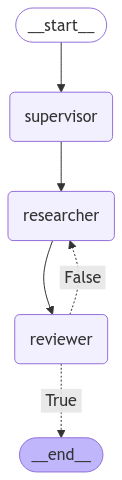

Workflow Response:
user: Can you research about the impact of AI on society?
supervisor: Initiating research for: Can you research about the impact of AI on society?
researcher: AI is having a significant impact on society, affecting various sectors.
reviewer: More detailed research needed.
researcher: 
AI is having a profound impact on society:

1. Healthcare: AI is improving diagnosis accuracy, drug discovery, and personalized treatment plans.
2. Education: AI-powered adaptive learning systems are tailoring education to individual needs.
3. Employment: While AI is automating some jobs, it's also creating new roles and industries.
4. Ethics and Privacy: The use of AI raises concerns about data privacy and ethical decision-making.
5. Economic Impact: AI is driving economic growth but also potentially widening wealth gaps.

reviewer: Research review complete. Found comprehensive information: 
AI is having a profound impact on society:

1. Healthcare: AI is improving diagnosis accuracy, 

In [2]:
import uuid
from typing import TypedDict, List, Dict, Any
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent
from operator import itemgetter
from langchain_core.tools import tool
from langchain_openai import AzureChatOpenAI
from IPython.display import Image, display

# Mock research data
mocked_research = "AI is having a significant impact on society, affecting various sectors."
mocked_research_detailed = """
AI is having a profound impact on society:

1. Healthcare: AI is improving diagnosis accuracy, drug discovery, and personalized treatment plans.
2. Education: AI-powered adaptive learning systems are tailoring education to individual needs.
3. Employment: While AI is automating some jobs, it's also creating new roles and industries.
4. Ethics and Privacy: The use of AI raises concerns about data privacy and ethical decision-making.
5. Economic Impact: AI is driving economic growth but also potentially widening wealth gaps.
"""

# Define the state
class GraphState(TypedDict):
    user_input: str
    research: str
    additional_research_requested: bool
    attempt_count: int
    messages: List[Dict[str, str]]

# Global variable to track research attempts
current_attempt = 0

# Global variable to print all messages or only the last one
print_all_messages = True

# Define the Research Tool
@tool
def perform_research(query: str) -> str:
    """Perform research based on the user's request."""
    global current_attempt
    # Return brief research on first attempt, detailed on subsequent attempts
    if current_attempt == 0:
        current_attempt += 1
        return mocked_research
    return mocked_research_detailed

# Define the Review Tool
@tool
def review_research(research: str) -> str:
    """Review the research results and determine if more details are needed."""
    if len(research) < 100:  # Simple heuristic for demonstration
        return "More detailed research needed."
    return f"Research review complete. Found comprehensive information: {research}"

# Define agent nodes
def researcher_node(state: GraphState) -> Dict:
    research_result = perform_research.invoke(state["user_input"])
    return {
        **state,
        "research": research_result,
        "attempt_count": state["attempt_count"] + 1,
        "messages": state["messages"] + [{"role": "researcher", "content": research_result}]
    }

def reviewer_node(state: GraphState) -> Dict:
    review_result = review_research.invoke(state["research"])
    needs_more = "more" in review_result.lower()
    return {
        **state,
        "additional_research_requested": needs_more,
        "messages": state["messages"] + [{"role": "reviewer", "content": review_result}]
    }

def supervisor_node(state: GraphState) -> Dict:
    return {
        **state,
        "messages": state["messages"] + [
            {"role": "supervisor", "content": f"Initiating research for: {state['user_input']}"}
        ]
    }

# Create the state graph
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("supervisor", supervisor_node)
workflow.add_node("researcher", researcher_node)
workflow.add_node("reviewer", reviewer_node)

# Set up the edges
workflow.set_entry_point("supervisor")
workflow.add_edge("supervisor", "researcher")
workflow.add_edge("researcher", "reviewer")

# Define finish condition
def is_finished(state: GraphState) -> bool:
    return state["attempt_count"] >= 2 or not state.get("additional_research_requested")

workflow.add_conditional_edges(
    "reviewer",
    is_finished,
    {
        True: END,
        False: "researcher"
    }
)

# Compile the graph
app = workflow.compile()

if DEBUG_MODE:
    # Display the Mermaid graph
    display(Image(app.get_graph().draw_mermaid_png()))

def process_user_input(user_input: str, session_id: str) -> str:
    global current_attempt
    current_attempt = 0  # Reset attempt counter for new request
    
    initial_state = {
        "user_input": user_input,
        "research": "",
        "additional_research_requested": False,
        "attempt_count": 0,
        "messages": [{"role": "user", "content": user_input}]
    }
    
    try:
        output = app.invoke(initial_state)
        messages = output.get("messages", [])
        
        # Count research iterations
        research_count = len([msg for msg in messages if msg["role"] == "researcher"])
        research_summary = f"\nResearch was performed {research_count} time(s)."
        
        if print_all_messages:
            return "\n".join([f"{msg['role']}: {msg['content']}" for msg in messages]) + research_summary
        else:
            reviewer_messages = [msg for msg in messages if msg["role"] == "reviewer"]
            if reviewer_messages:
                return reviewer_messages[-1]["content"] + research_summary
            else:
                return "No review results available." + research_summary
    
    except Exception as e:
        return f"Error processing request: {str(e)}"

# Example usage
if __name__ == "__main__":
    session_id = str(uuid.uuid4())
    user_input = "Can you research about the impact of AI on society?"
    response = process_user_input(user_input, session_id)
    print("Workflow Response:")
    print(response)
  